# Segmentation de noyau

L'objectif est de prendre en main un code qui permet d'entrainer un UNet. Nous utiliserons Python et quelques librairies pour la mise en forme.

## Installation des librairies

Il s'agit de librairies qui seront utilisées pour manipuler les images et le réseau de neurone. Il contient une fonction pour simplement rendre quelques images visibles à titre d'illustration.

In [ ]:
import os
import shutil
import sys
import random
import pickle
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from scipy import ndimage as ndi
from skimage import color, feature, restoration, measure

from skimage.filters import rank, sobel
from skimage.transform import resize
from skimage.feature import canny, peak_local_max

from skimage.color import label2rgb
from skimage.util import img_as_ubyte, random_noise

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from keras.losses import categorical_crossentropy
import tensorflow as tf

!pip install -U albumentations

def rgb_to_gray(img):
        gray = np.zeros(img.shape)
        R = np.array(img[:, :, 0])
        G = np.array(img[:, :, 1])
        B = np.array(img[:, :, 2])

        for i in range(3):
           gray[:,:,i] = R *.299 + G *.587 + B *.114

        return gray

def show_images(images,titles=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure(figsize=(20, 10))
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        a.grid(False)
        #plt.imshow(image, cmap=plt.cm.nipy_spectral)
        plt.imshow(image, cmap = plt.cm.gray)
        a.set_title(title)
        n += 1
    plt.show()

def dice_coef(y_true, y_pred, smooth=1e-3):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return K.mean((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

!pip install -U segmentation-models
!pip install livelossplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 23.1 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.2 MB/s eta 0:00:00


## Importation des données

Nous utilserons les données ESRF pour la pise en main du code. Cette base de données contient des images de noyau segmentée.

In [ ]:
!wget https://uabox.univ-angers.fr/index.php/s/uGDSduaidvtM2Oa/download/Data-20201209T234501Z-001.zip
!unzip -q "/content/Data-20201209T234501Z-001.zip"

--2025-02-04 00:05:58--  https://uabox.univ-angers.fr/index.php/s/uGDSduaidvtM2Oa/download/Data-20201209T234501Z-001.zip
Resolving uabox.univ-angers.fr (uabox.univ-angers.fr)... 193.49.144.31
Connecting to uabox.univ-angers.fr (uabox.univ-angers.fr)|193.49.144.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘Data-20201209T234501Z-001.zip’

Data-20201209T23450     [             <=>    ]  10.08M  2.84MB/s    in 4.2s    

2025-02-04 00:06:03 (2.37 MB/s) - ‘Data-20201209T234501Z-001.zip’ saved [10568707]



In [ ]:
import pickle
import os
DATA_DIR = '/content/Data'
# Loading training data CVPPP_RGB and lables from pickle file
TRAIN_PATH = os.path.join(DATA_DIR,'Train')
pickle_in = open(TRAIN_PATH + "/X_train_RGB.pickle","rb")
X_train = pickle.load(pickle_in)

pickle_in = open(TRAIN_PATH + "/Y_train_RGB.pickle","rb")
Y_train = pickle.load(pickle_in)

TEST_PATH = os.path.join(DATA_DIR,'Test')
# Loading training data and lables from pickle file
pickle_in = open(TEST_PATH+"/X_test.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in = open(TEST_PATH+"/Y_test.pickle","rb")
Y_test = pickle.load(pickle_in)
Y_test = Y_test.astype('float64')
print("Images en entrainement: ", len(X_train))
print("Images en test: ", len(X_test))

Images en entrainement:  783
Images en test:  38


La base de données d'entrainement contient très peu d'images pour entrainer le modèle. Or, il faut un grand volume d'images (soit environ 1000 images) pour bien concevoir un modèle.

In [ ]:
for ix in range(X_train.shape[0]):
  X_train[ix] = rgb_to_gray(X_train[ix])
Y_train = Y_train * 1.0

print(X_train.dtype,X_test.dtype)
print(X_train.shape,X_test.shape)
print(Y_train.dtype,Y_test.dtype)
print(Y_train.shape,Y_test.shape)

float64 float64
(783, 128, 128, 3) (38, 128, 128, 3)
float64 float64
(783, 128, 128, 3) (38, 128, 128, 3)


## Visualisation des images

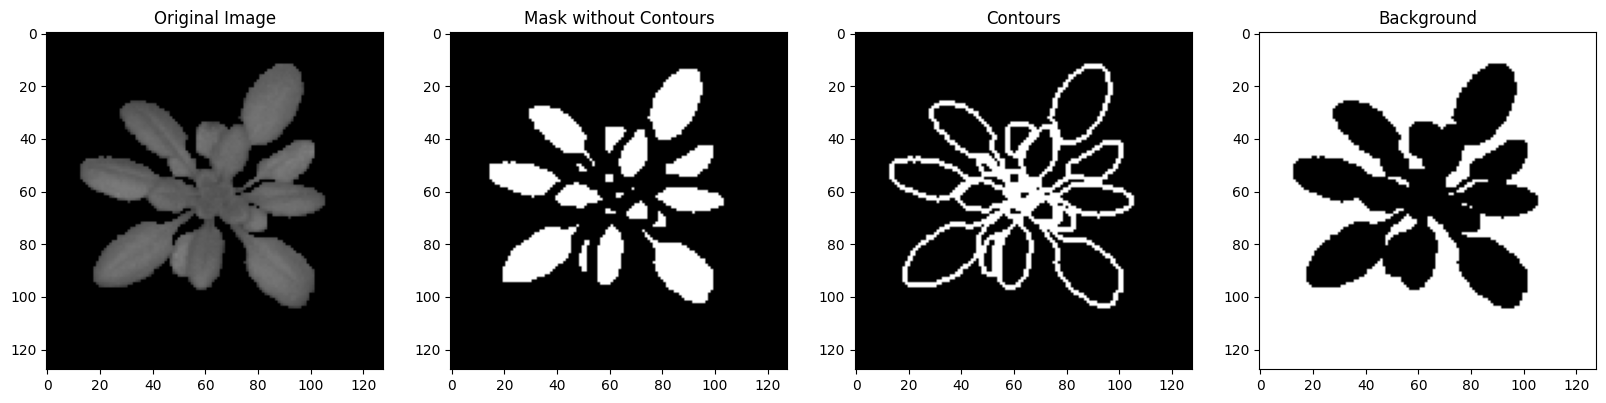

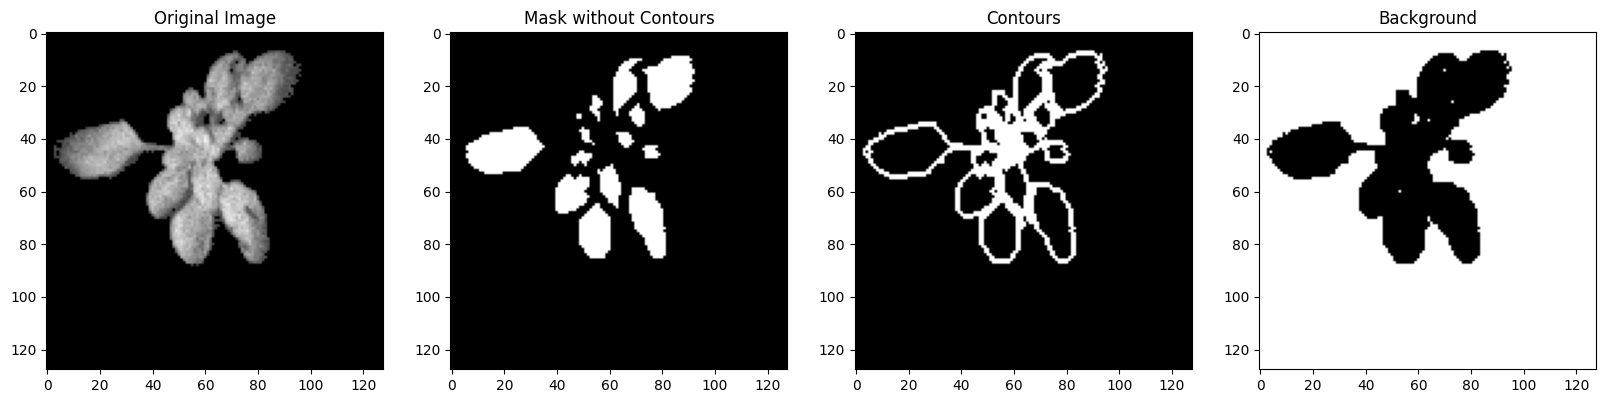

In [ ]:
ix = random.randint(0, len(X_train)-1)
show_images(images = [X_train[ix],Y_train[ix,:,:,0], Y_train[ix,:,:,1],Y_train[ix,:,:,2]],
            titles = ['Original Image', 'Mask without Contours', 'Contours', 'Background'])
ix = random.randint(0, len(X_test)-1)
show_images(images = [X_test[ix],Y_test[ix,:,:,0], Y_test[ix,:,:,1], Y_test[ix,:,:,2]],
            titles = ['Original Image', 'Mask without Contours', 'Contours', 'Background'])

## Solution pour augmenter notre jeu de données : data augmentation

**Data augmentation** : Technique pour générer à partir des images existantes de nouvelles images en utilisant des transformations géométriques. Elle a la qualité de fournir des images plus hétérogènes et augmente la taille de la base de données.

En théorie, il permet d'augmenter la performance de votre modèle à +3 et +4%.

*Exemple:* Supposons qu'une base de données contient 80% d'images sombres et 20% d'images avec trop de lumières. Pour équilibrer la luminosité dans la base de données, on génère 80% d'images avec trop de lumière à partir des images sombres.

In [ ]:
import albumentations as A
from albumentations import Compose, HorizontalFlip, RandomBrightnessContrast

IMG_WIDTH = 128
IMG_HEIGHT = 128

IMG_CHANNELS = 3
LABEL_CHANNELS = 3

aug_proportion = 0.8
n_aug = int(len(X_train) * aug_proportion)
X_aug = np.zeros((n_aug, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Y_aug = np.zeros((n_aug, IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype='float64') # Ensure Y_aug dtype matches Y_train

aug = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
])

for i in range(n_aug):
    augmented = aug(image=X_train[i], mask=Y_train[i])
    X_aug[i] = augmented['image']
    Y_aug[i] = augmented['mask']

print(X_aug.dtype, Y_aug.dtype)
print(X_aug.shape, Y_aug.shape)

float64 float64
(626, 128, 128, 3) (626, 128, 128, 3)


In [ ]:
x_train = np.concatenate([X_train, X_aug], axis=0) # Concatenate along the first axis (axis=0)
y_train = np.concatenate([Y_train, Y_aug], axis=0) # Concatenate along the first axis (axis=0)
idx = np.random.permutation(len(X_train))
x_train, y_train = x_train[idx], y_train[idx]

print(x_train.dtype, y_train.dtype)
print(x_train.shape, y_train.shape)

float64 float64
(783, 128, 128, 3) (783, 128, 128, 3)


## Visualisation des images avec data augmentation

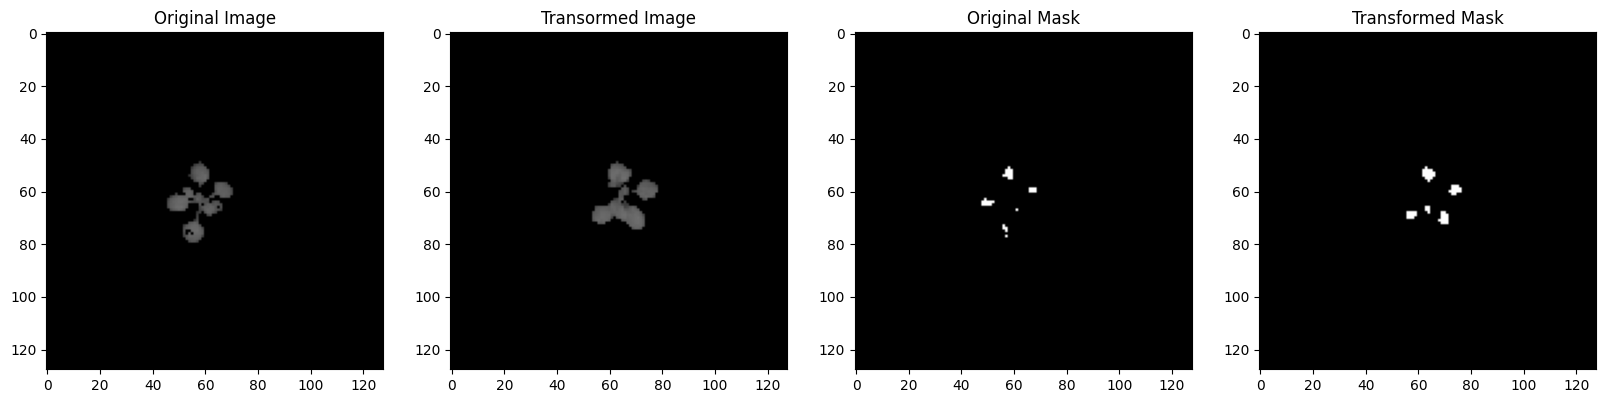

In [ ]:
ix = random.randint(0, len(X_aug))
show_images(images = [x_train[ix], X_aug[ix], y_train[ix,:,:,0],  Y_aug[ix,:,:,0]],
            titles = ['Original Image', 'Transormed Image', 'Original Mask', 'Transformed Mask'])

## Technique complémentaire pour augmenter la performance : transfert learning

**Transfert learning** : On entraine un modèle déjà entrainé avec nos images. Le modèle déjà entrainé contient des informations de la vie réel. En réentrainant ce modèle à partir de nos images, on demande au modèle de se concentrer sur une tache spécifique.

En théorie, il permet d'augmenter la performance à +2 ou +3%.

*Exemple* : En 2017, un réseau de neurone a été entrainé sur une base de données ImageNet (des millions d'images). Nous allons utilisé ce réseau pour concentrer la tache de segmentation sur nos fleurs.

In [ ]:
%env SM_FRAMEWORK=tf.keras
#import library
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [ ]:
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def weighted_cce_dice(weights):
  '''
  weight[0] = cce_w = 0.6
  weight[1] = border_w = 0.2
  weight[2] = mask_w = 0.2
  loss = 0.6*cce + 0.2*soft_dice_loss(mask) + 0.2*soft_dice_loss(border)
  '''

  weights = K.variable(weights)

  def loss(y_true, y_pred):
    return weights[0]*categorical_crossentropy(y_true, y_pred) + weights[1]*dice_coef_loss(y_true[..., 0], y_pred[..., 0]) + weights[2]*dice_coef_loss(y_true[..., 1], y_pred[..., 1])

  return loss

## Sans data augmentation et sans transfert learning

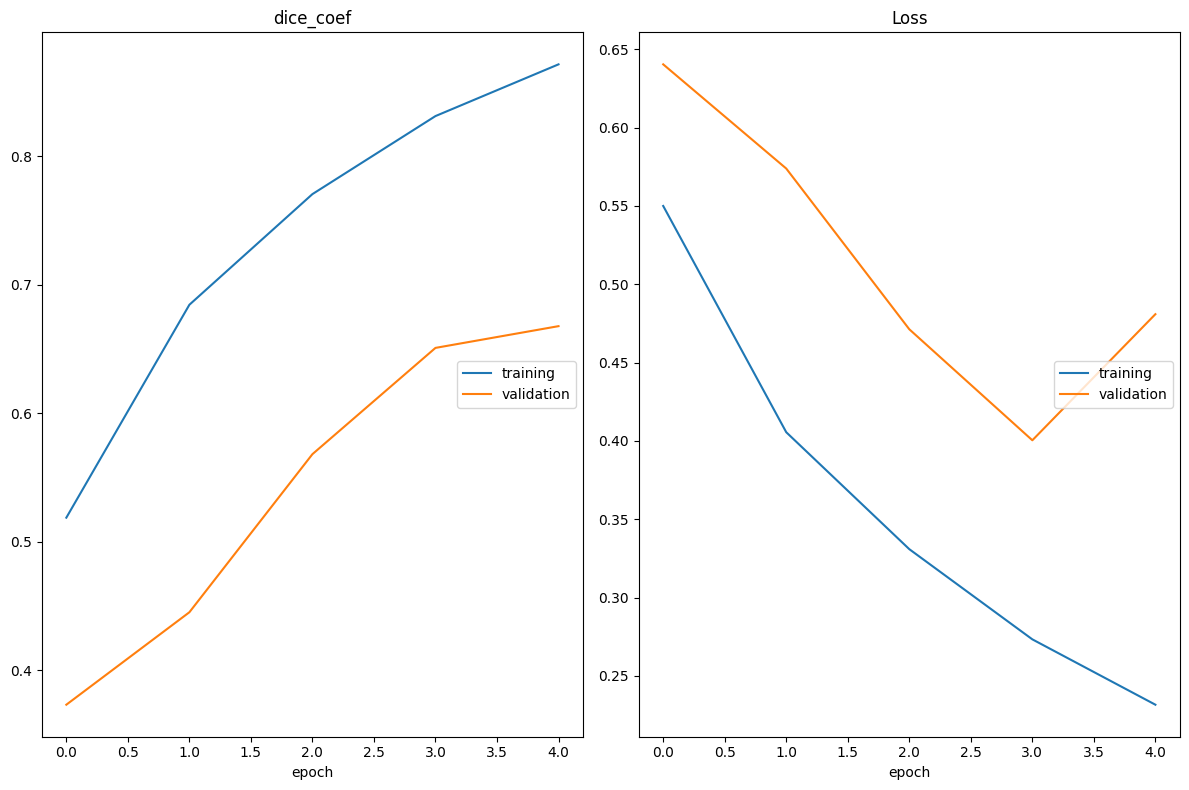

dice_coef
	training         	 (min:    0.519, max:    0.871, cur:    0.871)
	validation       	 (min:    0.373, max:    0.668, cur:    0.668)
Loss
	training         	 (min:    0.232, max:    0.550, cur:    0.232)
	validation       	 (min:    0.400, max:    0.640, cur:    0.481)

Epoch 5: val_loss did not improve from 0.40044
40/40 ━━━━━━━━━━━━━━━━━━━━ 770s 19s/step - dice_coef: 0.8629 - loss: 0.2413 - val_dice_coef: 0.6678 - val_loss: 0.4809


In [ ]:
BATCH_SIZE = 16
LR = 0.0001

EPOCHS = 5
OPTIMIZER = tf.keras.optimizers.Adam(LR)
# custom_loss = sm.losses.CategoricalCELoss()
custom_loss = weighted_cce_dice([0.4, 0.5, 0.1])
metric = dice_coef

# Train model
from livelossplot import PlotLossesKeras
plotlossesdeeper = PlotLossesKeras()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('UNET_VGG16_RGB.keras', verbose=1, save_best_only=True)

# Model compilation
BACKBONE = 'vgg16'
n_classes = 3
activation = 'softmax'
weights = None
# prepare model
model = sm.Unet(backbone_name=BACKBONE, encoder_weights=weights, classes = n_classes, activation=activation)
model.compile(optimizer =OPTIMIZER, loss = 'binary_crossentropy', metrics=[metric], run_eagerly=True)

history = model.fit(X_train, Y_train, validation_split=0.2,
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    callbacks=[plotlossesdeeper,earlystopper, checkpointer])

In [ ]:
# load model
model = load_model('/content/UNET_VGG16_RGB.keras', custom_objects={'loss': custom_loss, 'dice_coef': dice_coef})

eval_test = model.evaluate(X_test, Y_test)
print("Test Loss = " + str(eval_test[0]))
print("Test Dice_coef = " + str(eval_test[1]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - dice_coef: 0.7222 - loss: 0.3416
Test Loss = 0.34322643280029297
Test Dice_coef = 0.7159754037857056


## Avec data augmentation

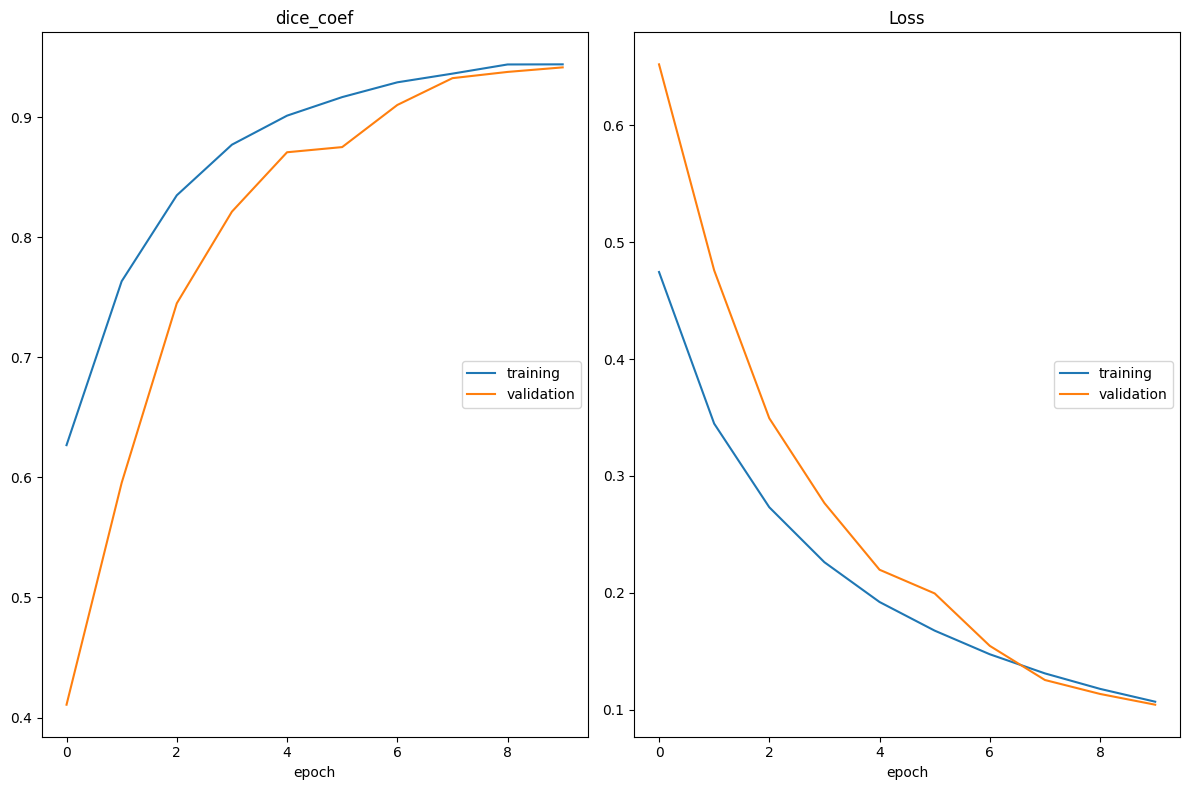

dice_coef
	training         	 (min:    0.627, max:    0.944, cur:    0.944)
	validation       	 (min:    0.411, max:    0.941, cur:    0.941)
Loss
	training         	 (min:    0.107, max:    0.475, cur:    0.107)
	validation       	 (min:    0.104, max:    0.652, cur:    0.104)

Epoch 10: val_loss improved from 0.11349 to 0.10428, saving model to UNET_VGG16_RGB.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 832s 20s/step - dice_coef: 0.9469 - loss: 0.1088 - val_dice_coef: 0.9414 - val_loss: 0.1043


In [ ]:
BATCH_SIZE = 16
LR = 0.0001

EPOCHS = 10
OPTIMIZER = tf.keras.optimizers.Adam(LR)
# custom_loss = sm.losses.CategoricalCELoss()
custom_loss = weighted_cce_dice([0.4, 0.5, 0.1])
metric = dice_coef

# Train model
from livelossplot import PlotLossesKeras
plotlossesdeeper = PlotLossesKeras()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('UNET_VGG16_RGB.keras', verbose=1, save_best_only=True)

# Model compilation
BACKBONE = 'vgg16'
n_classes = 3
activation = 'softmax'
weights = None
# prepare model
model = sm.Unet(backbone_name=BACKBONE, encoder_weights=weights, classes = n_classes, activation=activation)
model.compile(optimizer =OPTIMIZER, loss = 'binary_crossentropy', metrics=[metric], run_eagerly=True)

history = model.fit(x_train, y_train, validation_split=0.2,
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    callbacks=[plotlossesdeeper,earlystopper, checkpointer])

In [ ]:
# load model
model = load_model('/content/UNET_VGG16_RGB.keras', custom_objects={'loss': custom_loss, 'dice_coef': dice_coef})

eval_test = model.evaluate(X_test, Y_test)
print("Test Loss = " + str(eval_test[0]))
print("Test Dice_coef = " + str(eval_test[1]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - dice_coef: 0.9405 - loss: 0.0952
Test Loss = 0.09811733663082123
Test Dice_coef = 0.9323400259017944


## Avec data augmentation et transfert learning

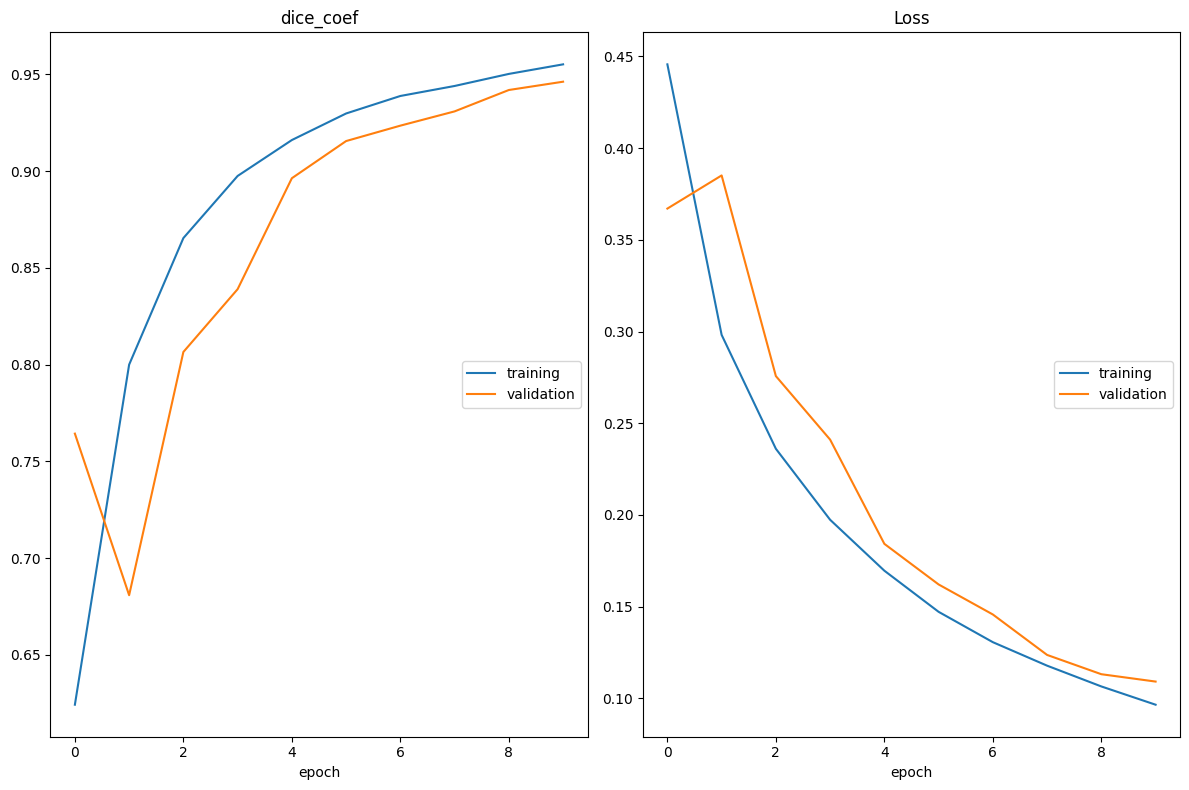

dice_coef
	training         	 (min:    0.624, max:    0.955, cur:    0.955)
	validation       	 (min:    0.681, max:    0.946, cur:    0.946)
Loss
	training         	 (min:    0.097, max:    0.446, cur:    0.097)
	validation       	 (min:    0.109, max:    0.385, cur:    0.109)

Epoch 10: val_loss improved from 0.11320 to 0.10919, saving model to UNET_VGG16_RGB.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 801s 19s/step - dice_coef: 0.9545 - loss: 0.0980 - val_dice_coef: 0.9462 - val_loss: 0.1092


In [ ]:
BATCH_SIZE = 16
LR = 0.0001

EPOCHS = 10
OPTIMIZER = tf.keras.optimizers.Adam(LR)
# custom_loss = sm.losses.CategoricalCELoss()
custom_loss = weighted_cce_dice([0.4, 0.5, 0.1])
metric = dice_coef

# Train model
from livelossplot import PlotLossesKeras
plotlossesdeeper = PlotLossesKeras()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('UNET_VGG16_RGB.keras', verbose=1, save_best_only=True)

# Model compilation
BACKBONE = 'vgg16'
n_classes = 3
activation = 'softmax'
weights = 'imagenet'
# prepare model
model = sm.Unet(backbone_name=BACKBONE, encoder_weights=weights, classes = n_classes, activation=activation)
model.compile(optimizer =OPTIMIZER, loss = 'binary_crossentropy', metrics=[metric], run_eagerly=True)

history = model.fit(x_train, y_train, validation_split=0.2,
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    callbacks=[plotlossesdeeper,earlystopper, checkpointer])

In [ ]:
# load model
model = load_model('/content/UNET_VGG16_RGB.keras', custom_objects={'loss': custom_loss, 'dice_coef': dice_coef})

eval_test = model.evaluate(X_test, Y_test)
print("Test Loss = " + str(eval_test[0]))
print("Test Dice_coef = " + str(eval_test[1]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - dice_coef: 0.9371 - loss: 0.1102
Test Loss = 0.11314531415700912
Test Dice_coef = 0.9283602833747864
